In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Visualizing Masked Self-Attention


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from src.layers.attention import scaled_dot_product_attention
from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model
from src.models.astromer_0 import positional_encoding
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from astropy.timeseries import LombScargle
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2025-07-15 02:43:20.347712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 02:43:20.347761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 02:43:20.347787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 02:43:20.355033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model_path_0 = './presentation/results/paper/pretraining/'
model_path_1 = './presentation/results/diagstromer/2024-12-02_14-13-12/pretraining/'
models = []
configs = []
for m in [model_path_0, model_path_1]:
    astromer, config = load_pt_model(m)
    models.append(astromer)
    configs.append(config)

label = ['Astromer v0', 'Astromer v1']

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


In [33]:
dsname = 'alcock'
data = './data/shared/records/{}/fold_0/{}_20/'.format(dsname, dsname)
batch_size = 1
loaders = build_loader(data, 
                       params=config,
                       batch_size=batch_size, 
                       sampling=True,
                       return_test=False,
                       shuffle=True,
                       probed=0.3,
                       random=0.0,
                       same=0.0,
                       clf_mode=False,
                    )

metadata = pd.read_parquet('./data/raw_parquet/{}/metadata.parquet'.format(dsname))

[INFO] String based loader
[INFO] Changing path:  ./data/shared/records/alcock/fold_0/alcock_20/val
[INFO] Probed: 0.30 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Cache activated
[INFO] Probed: 0.30 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows


# Visualizing Attention

In [29]:
def fold_curve(times, magnitudes):
    """
    Calcula el período principal y devuelve los índices para ordenar por fase.
    """
    times_jittered = times + np.random.normal(0, 1e-8, size=len(times))
    frequency, power = LombScargle(times_jittered, magnitudes).autopower(minimum_frequency=0.1, maximum_frequency=1.5)
    
    if not np.any(power > 0):
        return np.arange(len(times)), 1.0 # Devuelve período 1.0 si no se encuentra

    best_frequency = frequency[np.argmax(power)]
    period = 1 / best_frequency
    phase = (times % period) / period
    indices = np.argsort(phase)
    return indices, period

In [30]:
metadata['Class'].unique()

array(['LPV', 'Cep_0', 'RRab', 'RRc', 'EC', 'UNK', 'Cep_1'], dtype=object)

In [35]:
if dsname == 'alcock':
    datasplitted = {
        'LPV': [], 'Cep_0': [], 'RRab': [], 'RRc': [], 'EC': [], 'UNK': [], 'Cep_1': []
    }

if dsname == 'atlas':
    datasplitted = {
        'DB': [],
        'CB': [],
        'Pulse': [],
        'Mira': []
    }
for batch, batch_out in loaders['validation']:
    id_lc = batch_out['lcid'][0].numpy().decode()
    lc_metadata = metadata[metadata['ID'].astype(str) == str(id_lc)]
    class_name = lc_metadata['Class'].values[0]
    if class_name not in datasplitted.keys():
        print(class_name)
        continue
    predictions = models[-1](batch, training=False)
    predicted_sequence = predictions[0, ..., 0].numpy()
    mask_in = batch['mask_in'][0, :, 0].numpy()
    times = batch['times'][0, :, 0].numpy()
    true_sequence = batch_out['target'][0, :, 0].numpy()
    is_masked = mask_in == 1

    sample_x = {
        'id_lc': id_lc,
        'predicted_sequence': predicted_sequence,
        'mask_in': mask_in,
        'times': times,
        'true_sequence': true_sequence,
        'is_masked': is_masked
    }

    datasplitted[class_name].append(sample_x)

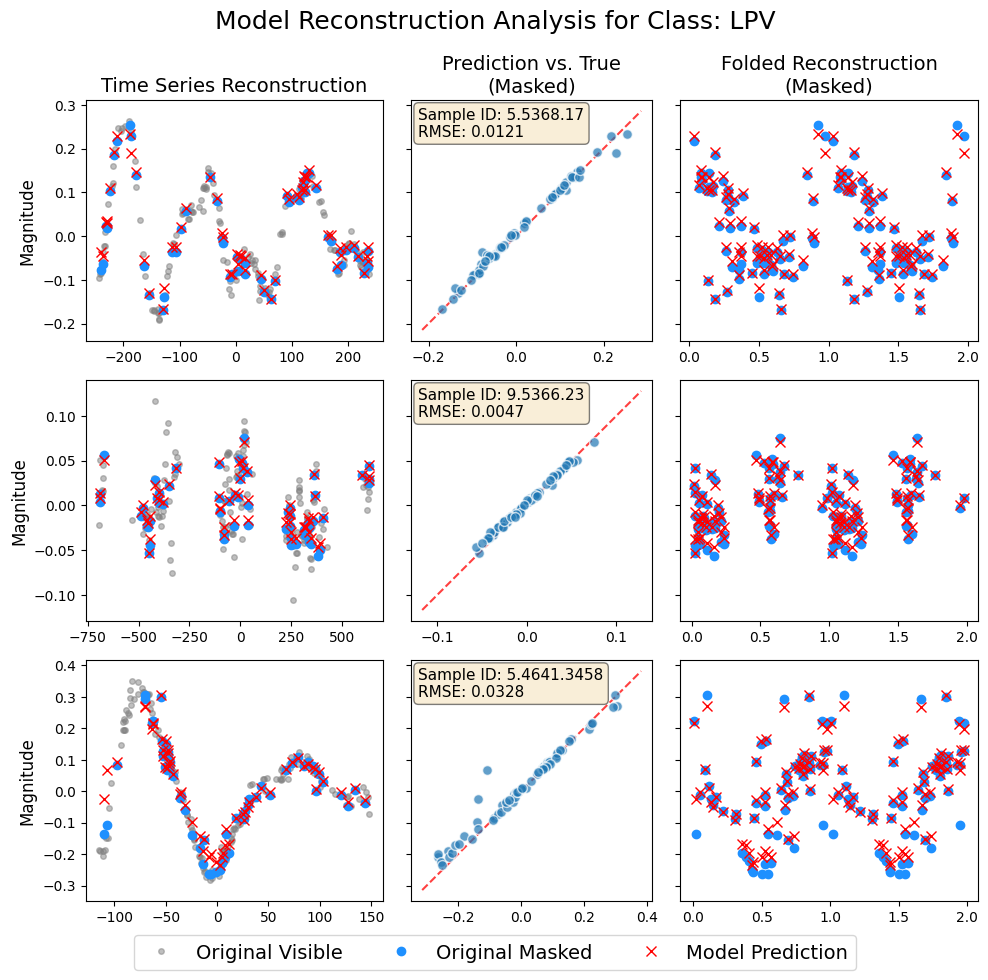

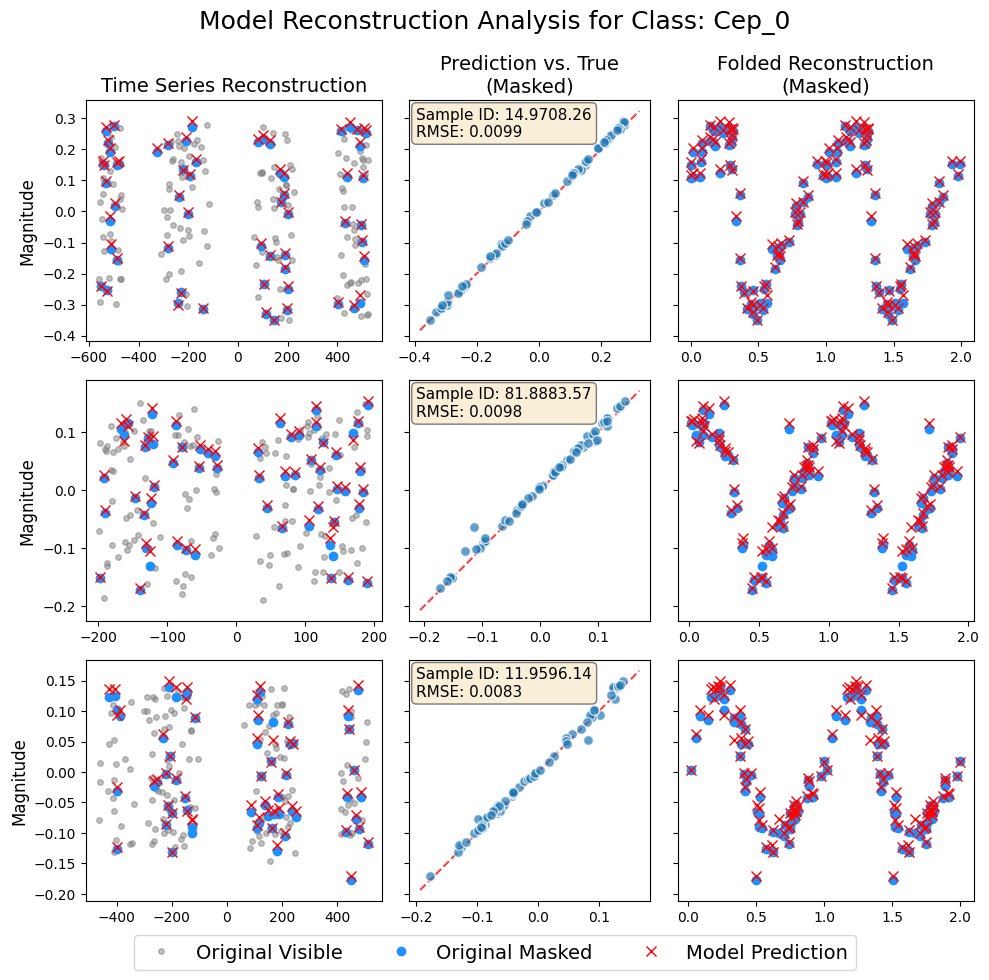

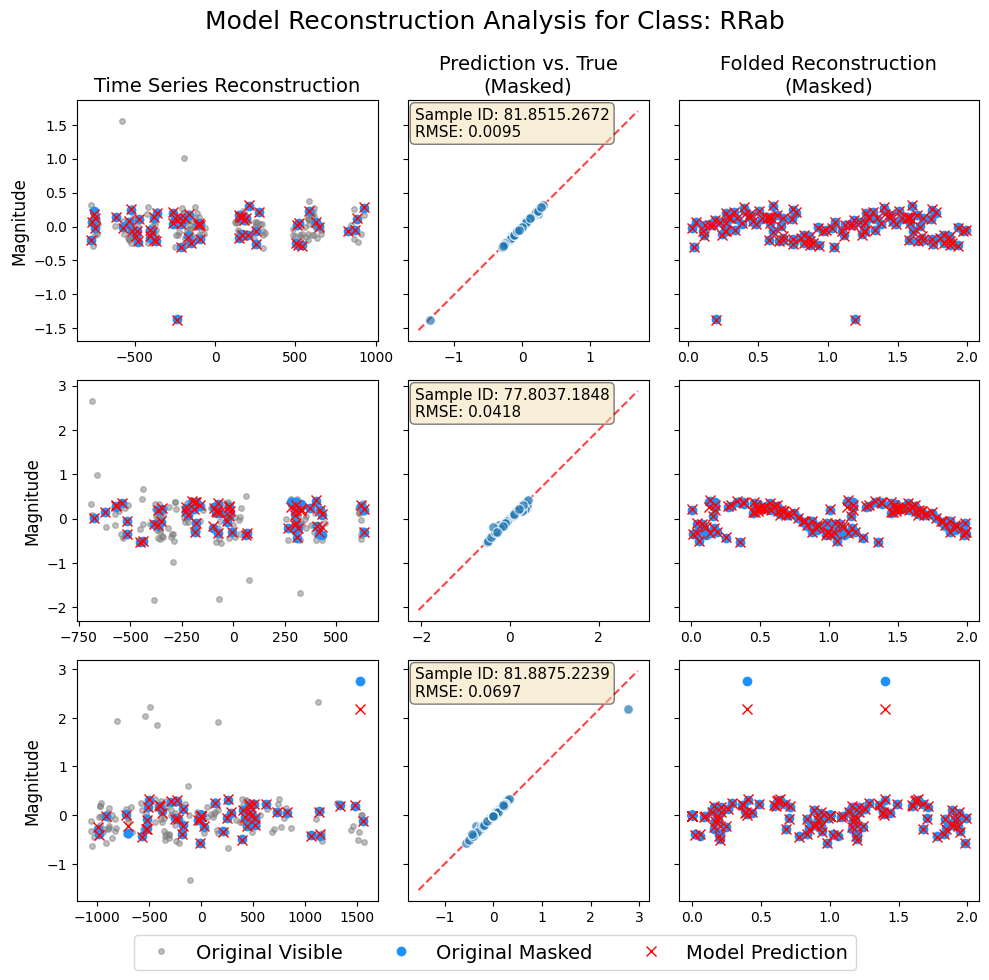

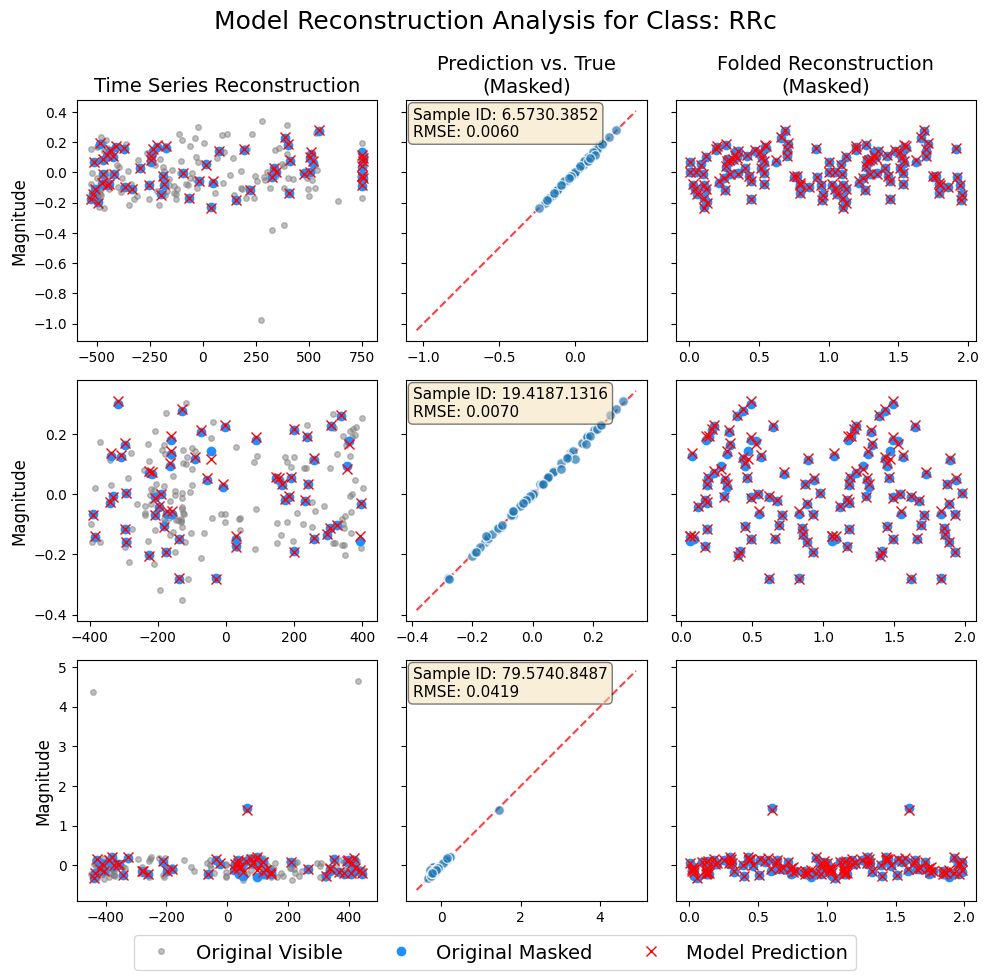

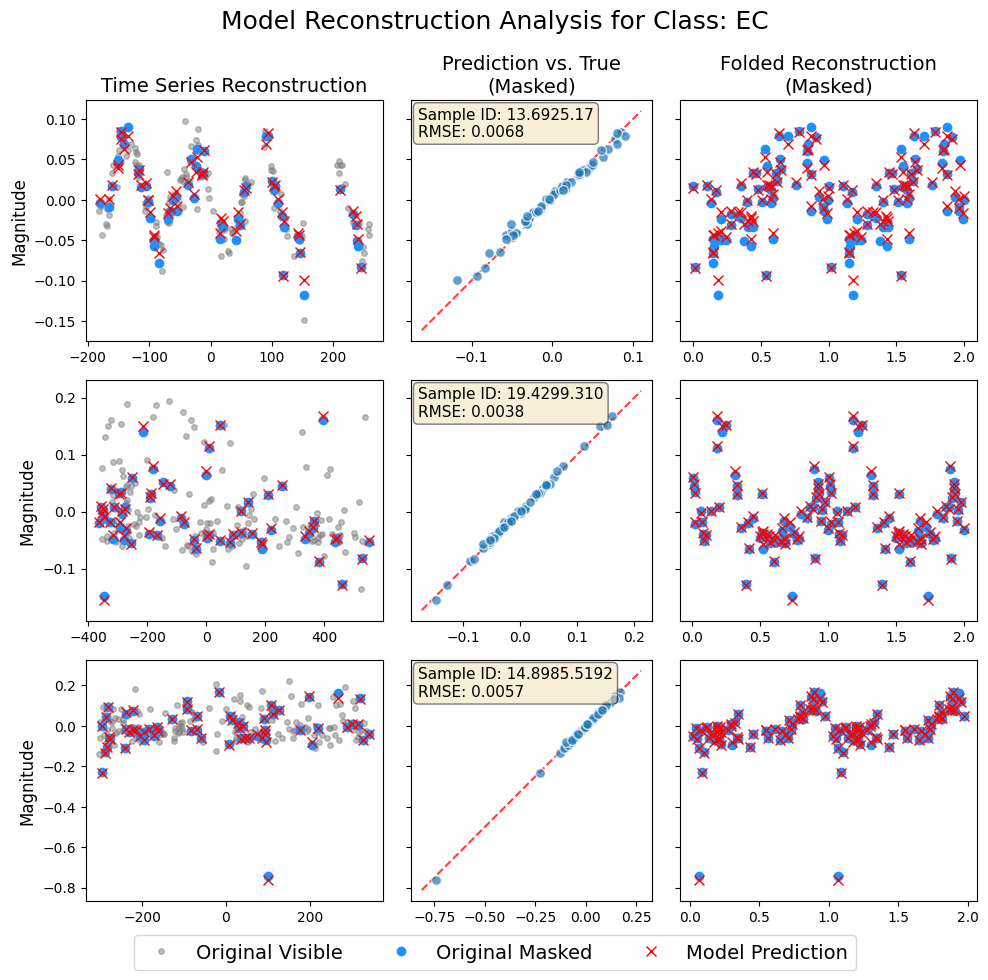

Clase 'UNK' tiene menos de 3 muestras, se omite.


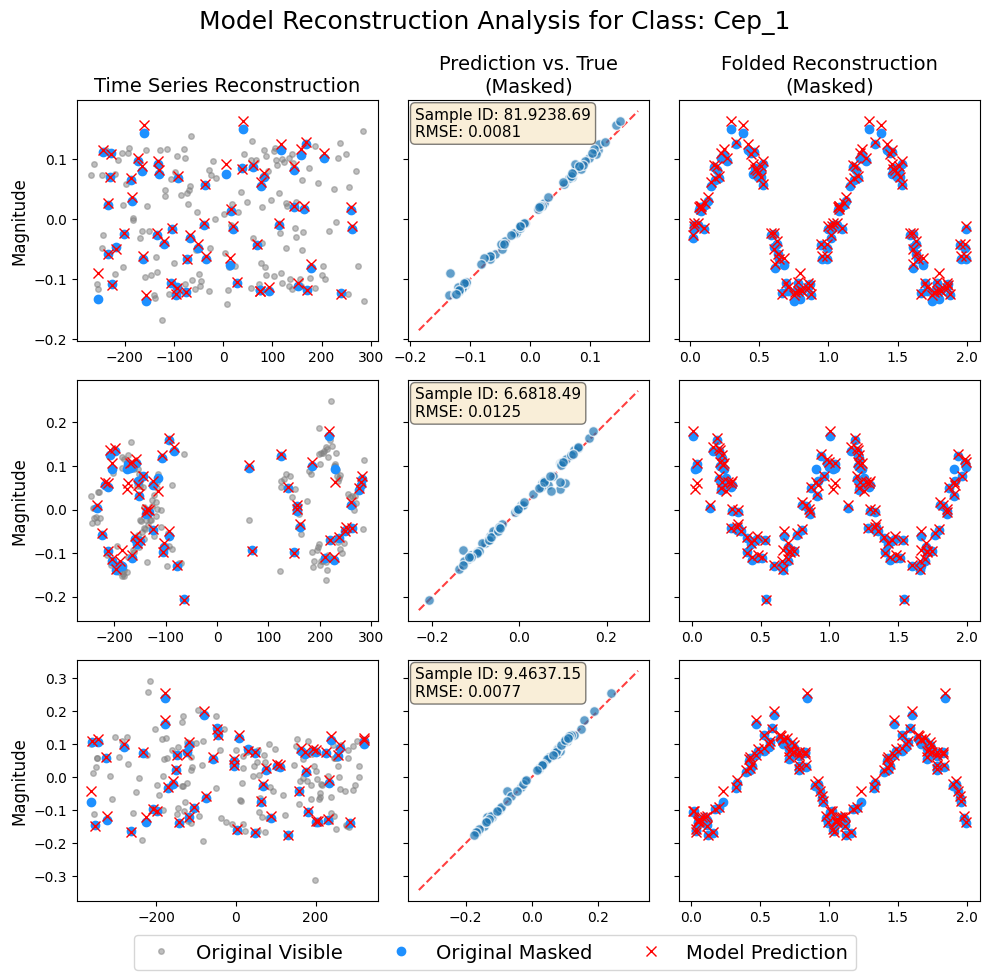

In [61]:
# --- Bucle principal para generar una figura por clase ---
for class_name, all_samples in datasplitted.items():
    
    # Asegurarse de que hay suficientes muestras para elegir
    if len(all_samples) < 3:
        print(f"Clase '{class_name}' tiene menos de 3 muestras, se omite.")
        continue

    # Seleccionar 3 muestras aleatorias sin reemplazo
    selected_samples = random.sample(all_samples, 3)

    # Crear la figura y la grilla de ejes de 3x3
    fig, axes = plt.subplots(3, 3, figsize=(10, 10), gridspec_kw={'wspace':0.}, sharey='row')
    fig.text(
        0.5,  # Posición X (0.5 es el centro horizontal de la figura)
        0.98, # Posición Y (0.98 es cerca de la parte superior)
        f"Model Reconstruction Analysis for Class: {class_name}", # El texto
        ha='center', # Alineación horizontal obligatoria para centrar
        va='top',    # Alineación vertical
        fontsize=18  # Tamaño de la fuente
    )

    # Iterar sobre las 3 muestras seleccionadas y las filas de la grilla
    for i, sample in enumerate(selected_samples):
        # Extraer datos de la muestra
        times              = sample['times']
        true_sequence      = sample['true_sequence']
        predicted_sequence = sample['predicted_sequence']
        is_masked          = sample['is_masked']
        lc_id              = sample['id_lc']

        # Ejes para la fila actual
        ax1, ax2, ax3 = axes[i]
        
        # --- Gráfico 1: Reconstrucción en el Tiempo ---
        ax1.plot(times[~is_masked], true_sequence[~is_masked], 'o', c='grey', ms=4, alpha=0.5, label='Original Visible')
        ax1.plot(times[is_masked], true_sequence[is_masked], 'o', c='dodgerblue', ms=6, label='Original Masked')
        ax1.plot(times[is_masked], predicted_sequence[is_masked], 'x', c='red', ms=7, mew=1, label='Model Prediction')
        ax1.invert_yaxis()
        ax1.set_ylabel("Magnitude", fontsize=12)
        
        # --- Gráfico 2: Dispersión Real vs. Predicción ---
        masked_true = true_sequence[is_masked]
        masked_pred = predicted_sequence[is_masked]
        rmse = np.sqrt(mean_squared_error(masked_true, masked_pred))

        ax2.scatter(masked_true, masked_pred, alpha=0.7, edgecolors='w', s=50)
        lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]), np.max([ax2.get_xlim(), ax2.get_ylim()])]
        ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
        ax2.set_aspect('equal', 'box')
        
        # --- Gráfico 3: Curva Foldeada ---
        _, period = fold_curve(times, true_sequence)
        phase = (times[is_masked] % period) / period
        sort_idx = np.argsort(phase)
        
        plot_phase = np.concatenate((phase[sort_idx], phase[sort_idx] + 1))
        plot_true = np.concatenate((masked_true[sort_idx], masked_true[sort_idx]))
        plot_pred = np.concatenate((masked_pred[sort_idx], masked_pred[sort_idx]))

        ax3.plot(plot_phase, plot_true, 'o', c='dodgerblue', ms=6)
        ax3.plot(plot_phase, plot_pred, 'x', c='red', ms=7, mew=1)
        ax3.invert_yaxis()
        
        # --- Títulos y Anotaciones ---
        # 1. Añadir la información de la muestra como un texto dentro del primer gráfico (ax1)
        #    Esto se hará para CADA fila (i=0, 1, 2)
        ax2.text(0.03, 0.97, f"Sample ID: {lc_id}\nRMSE: {rmse:.4f}",
                 transform=ax2.transAxes, # Coordenadas relativas al eje
                 fontsize=11,
                 verticalalignment='top', # Alinea el texto desde arriba
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
        # 2. Añadir los títulos de las columnas, pero SOLO para la primera fila (i=0)
        if i == 0:
            ax1.set_title("Time Series Reconstruction", fontsize=14, loc='center')
            ax2.set_title("Prediction vs. True\n(Masked)", fontsize=14, loc='center')
            ax3.set_title("Folded Reconstruction\n(Masked)", fontsize=14, loc='center')


    # --- Leyenda Compartida ---
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=3, fontsize=14)
    
    fig.tight_layout(rect=[0, 0.05, 1, 0.95]) # Ajustar para suptitle y leyenda
    fig.savefig('./presentation/figures/reconstruction/{}.pdf'.format(class_name), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [169]:
# plt.figure(dpi=200)
# plt.imshow(att_weigths[0], cmap='inferno')
# plt.title('Attention Weigths')
# plt.colorbar()
# plt.show()

## Getting Q, K, and V

In [67]:
encoder = models[0].get_layer('encoder')
config = configs[0]
for batch, _ in loaders['train'].take(1):
    if config['arch'] == 'base':
        x, _ = encoder.input_format(batch)
        x = encoder.dropout_layer(x, training=False)

    if config['arch'] == 'zero':
        x_pe = positional_encoding(batch['times'], config['num_heads']*config['head_dim'], mjd=True)
        x_transformed = encoder.inp_transform(batch['input'])
        transformed_input = x_transformed + x_pe
        x = encoder.dropout(transformed_input, training=False)

    Q = encoder.enc_layers[-1].mha.wq(x)
    Q = encoder.enc_layers[-1].mha.split_heads(Q, batch_size=batch_size)

    K = encoder.enc_layers[-1].mha.wk(x)
    K = encoder.enc_layers[-1].mha.split_heads(K, batch_size=batch_size)

    V = encoder.enc_layers[-1].mha.wv(x)
    V = encoder.enc_layers[-1].mha.split_heads(V, batch_size=batch_size)

    mask = batch['mask_in']

2024-12-05 02:13:45.341438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Effect of temperature

In [56]:
w = []
temps = [1, 2]#np.arange(0.5, 3, 0.5)
for t in temps:
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, 
                                                                                  K, 
                                                                                  V, 
                                                                                  mask=tf.zeros_like(mask), 
                                                                                  m_alpha=-1e9, 
                                                                                  mask_format='K',
                                                                                  temperature=t)
    
    w.append(attention_weights)

In [57]:
master = w[-1][0, 0, :, 0]

attention_vectors = []
for ww in w:
    master = ww[0, 0, 10, :]
    attention_vectors.append(master)

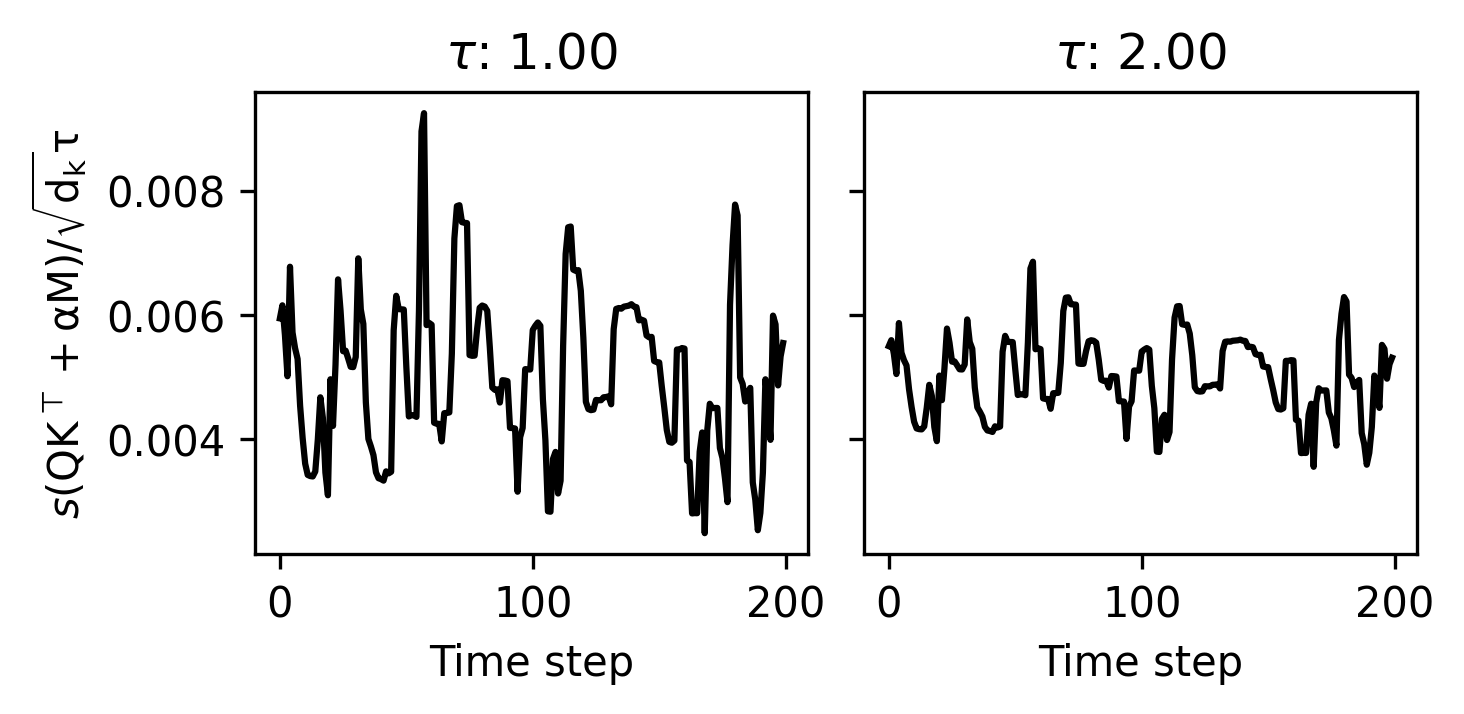

In [59]:
fig, axes = plt.subplots(1, len(temps), figsize=(5,2.), sharey=True, dpi=300, gridspec_kw={'wspace':0.1})

for index, av in enumerate(attention_vectors):
    axes[index].plot(av, color='k')
    axes[index].set_title(r'$\tau$: {:.2f}'.format(temps[index]))
    axes[index].set_xlabel('Time step')
    # axes[index].set_yscale('log')
    
axes[0].set_ylabel(r'$s(\rm{QK}^{\top} +\alpha\rm{M})/\sqrt{d_k}\tau$')
fig.savefig('./presentation/figures/temperature.pdf', format='pdf', bbox_inches='tight')

### Effect of alpha when masking via softmax arg

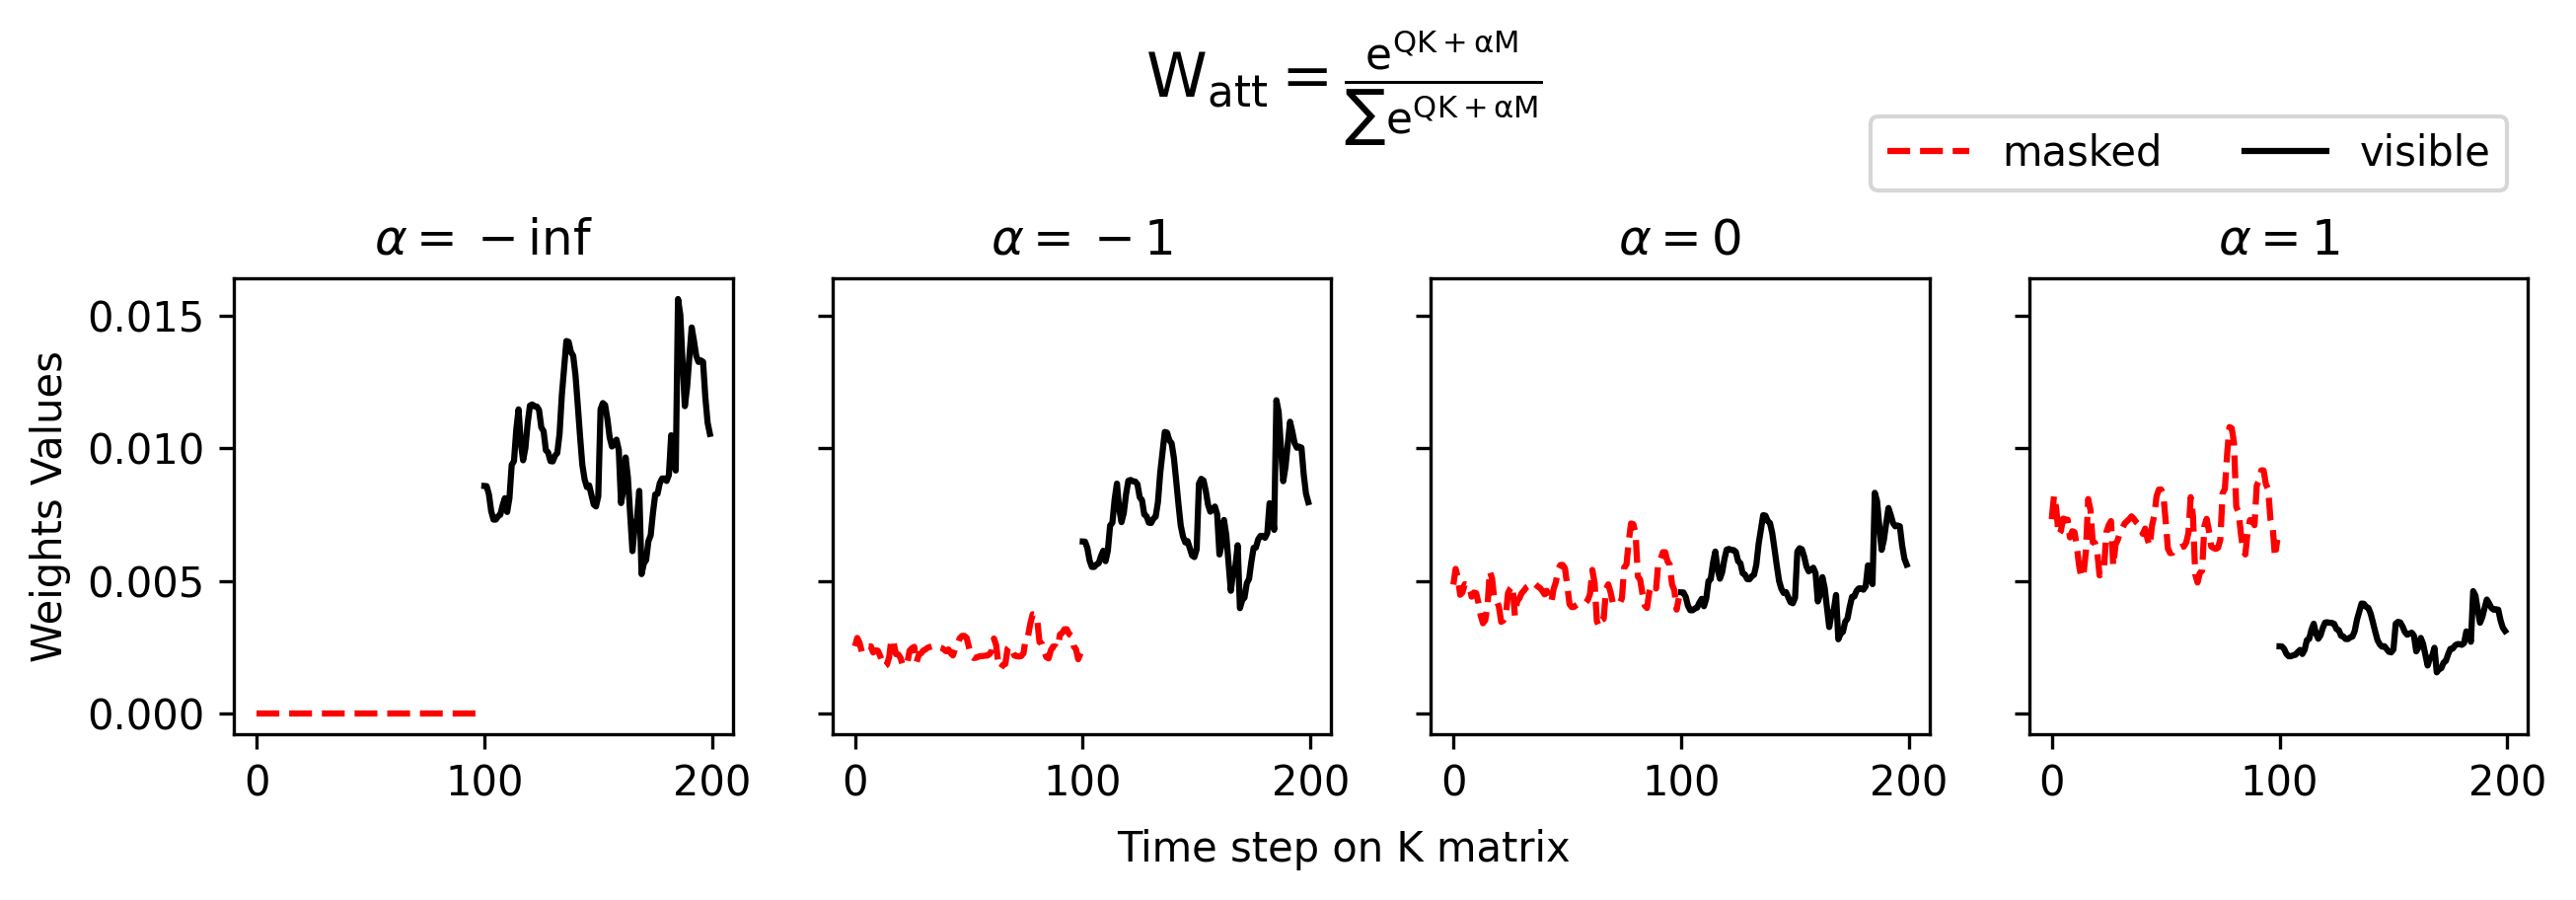

In [30]:
alphas = [-1e9, -1, 0, 1]
labels = [r'$\alpha=-\inf$', r'$\alpha=-1$', r'$\alpha=0$', r'$\alpha=1$']

fig, axes = plt.subplots(1, 4, figsize=(10, 2), dpi=300, sharey=True)
axes = axes.flatten()
sim_matrices = []
for i, alp in enumerate(alphas):
    mask_dim = mask.shape
    neg = tf.ones([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    pos = tf.zeros([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    mask_new = tf.concat([neg, pos], 1)
    
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, K, V, mask=mask_new, m_alpha=alp, mask_format='K')


    v = attention_weights[0, 0, 0]

    axes[i].plot(range(0, 100), v[:100], label='masked', color='red', linestyle='--')
    axes[i].plot(range(100, 200), v[100:200], label='visible', color='k')
    axes[i].set_title('{}'.format(labels[i]))
    # axes[i].set_yscale('log')
    # axes[i].set_xlabel('Time Step on K')
    sim_matrices.append(attention_weights[0, 0])

axes[-1].legend(bbox_to_anchor=(1., 1.4), ncols=2)
axes[0].set_ylabel('Weights Values')
fig.text(0.5,1.3,r'$\rm{W}_{att} = \frac{e^{QK + \alpha M}}{\sum e^{QK+ \alpha M}}$',horizontalalignment='center',
       verticalalignment='top', fontsize=15)
fig.text(0.5,-0.05,'Time step on K matrix',horizontalalignment='center',
       verticalalignment='top', fontsize=10)
fig.savefig('./presentation/figures/alpha_on_weights.pdf', format='pdf', bbox_inches='tight')
